# Denoising Autoencoder

To start the backend:
```
sudo docker run -it --rm --runtime=nvidia -v $(realpath ~/Documents/ML):/tf/notebooks -p 8888:8888 tensorflow/tensorflow:latest-gpu-jupyter
```

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.client import device_lib
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import os

# Needed when using the docker backend
if 'notebooks' in os.listdir():
    os.chdir('notebooks')

# Check if the GPU is detected
local_device_protos = device_lib.list_local_devices()
[x.name for x in local_device_protos]

2023-07-24 17:30:03.636720: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-24 17:30:03.754380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 17:30:05.444712: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 17:30:05.460930: I tensorflow/comp

['/device:CPU:0', '/device:GPU:0']

In [45]:
TILE_SIZE = 128
TILES_PER_IMAGE = 30

EPOCHS_COUNT = 200

WITH_GEOMETRY = True

GEOMETRY_CHANNELS_COUNT = 4 if WITH_GEOMETRY else 0
INPUT_CHANNELS_COUNT = 3 + GEOMETRY_CHANNELS_COUNT

MODEL_NAME = str(EPOCHS_COUNT) + '-with' + ('' if WITH_GEOMETRY else 'out') + '-geometry'

In [3]:
def read_image_file(filename, geometry_file = None):
    WIDTH, HEIGHT = 1024, 1024

    # return tf.constant(np.random.rand(HEIGHT, WIDTH, 3 + (GEOMETRY_CHANNELS_COUNT if geometry_file is not None else 0)), dtype=tf.float16)

    image_data = []
    with open(filename, 'r') as file:
        for line in file:
            values = line.strip().split()
            image_data.append([float(value) for value in values])

    if WITH_GEOMETRY and geometry_file is not None:
        with open(geometry_file, 'r') as file:
            for i, line in enumerate(file):
                values = [float(v) for v in line.strip().split()]
                assert(values[0] <= 100)
                values[0] /= 20 # TODO specific for this scene.. TODO divide by the max
                image_data[i] += values

    image_tensor = tf.constant(image_data, dtype=np.float16)
    image_tensor = tf.reshape(image_tensor, [HEIGHT, WIDTH, 3 + (GEOMETRY_CHANNELS_COUNT if geometry_file is not None else 0)])

    # TODO the file is not stored line by line
    image_tensor = tf.image.rot90(image_tensor)

    return image_tensor


def display_img(img):
    plt.imshow(img.numpy().astype(np.float32)[:,:,:3])
    plt.axis('off')
    plt.show()

In [4]:
def generate_tiles(img, n, seed=0):
    # return [tf.convert_to_tensor(np.random.rand(TILE_SIZE, TILE_SIZE, len(img[0][0])), dtype=tf.float16) for _ in range(n)]
    return [
        tf.image.stateless_random_flip_left_right(
            tf.image.stateless_random_crop(img, size=(TILE_SIZE, TILE_SIZE, len(img[0][0])), seed=(seed, i)),
            seed=(seed, i)
        )
        for i in range(n)
    ]

def display_tile_grid(tiles, lines_count=4, columns_count=2, size=2):
    fig, axes = plt.subplots(lines_count, columns_count*len(tiles), figsize=(size*columns_count*len(tiles), size*lines_count))

    for i in range(lines_count):
        for j in range(columns_count):
            for k in range(len(tiles)):
                ax = axes[i, j*len(tiles) + k]
                ax.imshow(tiles[k][i*columns_count + j].numpy().astype(np.float32)[:,:,:3])
                ax.axis('off')

    fig.tight_layout()
    plt.show()

In [5]:
images = []
for i in range(30):
    for c in ['a', 'b', 'c']:
        folder = 'data/output-' + str(i).zfill(4)
        img_input = read_image_file(folder + '/raw-output-00004-' + c, geometry_file = folder + '/geometry')
        img_output = read_image_file(folder + '/raw-output-10000')

        images.append((img_input, img_output))

2023-07-24 17:30:07.726103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 17:30:07.726223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 17:30:07.726262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


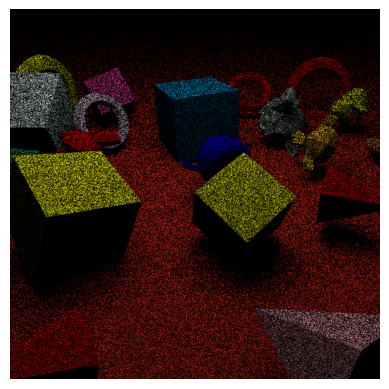

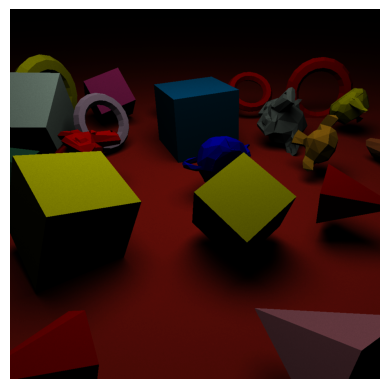

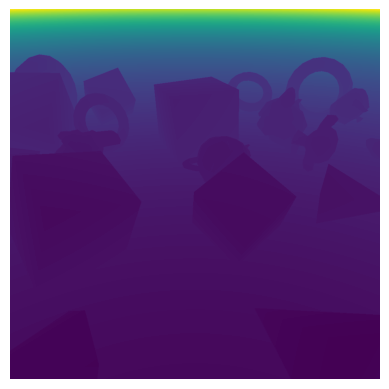

In [6]:
display_img(images[0][0])
display_img(images[0][1])

if WITH_GEOMETRY:
    plt.imshow(images[0][0][:,:,3])
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


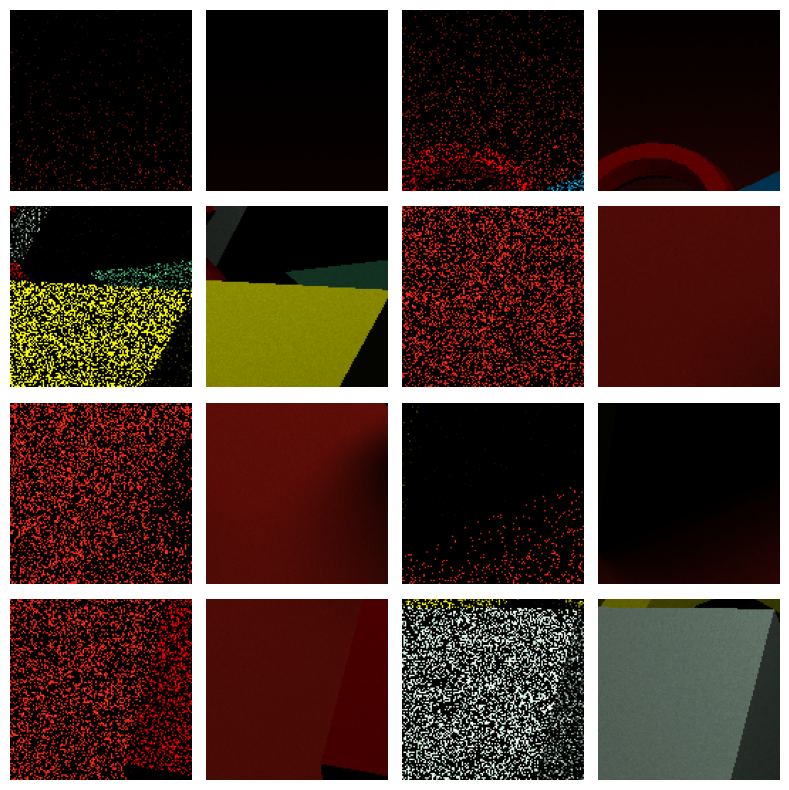

In [7]:
tiles_input = []
tiles_expected = []

for i in range(30):
    for j in range(3):
        img_input, img_expected = images[i*3 + j]

        tiles_input += generate_tiles(img_input, TILES_PER_IMAGE, seed=i)
        tiles_expected += generate_tiles(img_expected, TILES_PER_IMAGE, seed=i)

tiles_input, tiles_expected = tf.convert_to_tensor(tiles_input), tf.convert_to_tensor(tiles_expected)

display_tile_grid([tiles_input, tiles_expected])

In [8]:
# Validation
validation_images = []
for i in range(34, 36):
    for c in ['a']:
        folder = 'data/output-' + str(i).zfill(4)
        img_input = read_image_file(folder + '/raw-output-00004-' + c, geometry_file = folder + '/geometry')
        img_output = read_image_file(folder + '/raw-output-10000')

        validation_images.append((img_input, img_output))

validation_tiles_input = []
validation_tiles_expected = []

for img_input, img_expected in validation_images:
    validation_tiles_input += generate_tiles(img_input, TILES_PER_IMAGE)
    validation_tiles_expected += generate_tiles(img_expected, TILES_PER_IMAGE)

validation_tiles_input, validation_tiles_expected = tf.convert_to_tensor(validation_tiles_input), tf.convert_to_tensor(validation_tiles_expected)

## CNN

In [46]:
input_shape = (None, None, INPUT_CHANNELS_COUNT)

inputs = tf.keras.Input(shape=input_shape)

x_128 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)

x_64 = layers.MaxPooling2D((2, 2))(x_128)
x_64 = layers.Conv2D(43, (3, 3), activation='relu', padding='same')(x_64)

x_32 = layers.MaxPooling2D((2, 2))(x_64)
x_32 = layers.Conv2D(57, (3, 3), activation='relu', padding='same')(x_32)

x_16 = layers.MaxPooling2D((2, 2))(x_32)
x_16 = layers.Conv2D(76, (3, 3), activation='relu', padding='same')(x_16)

x_8 = layers.MaxPooling2D((2, 2))(x_16)
x_8 = layers.Conv2D(101, (3, 3), activation='relu', padding='same')(x_8)

x_4 = layers.MaxPooling2D((2, 2))(x_8)
x_4 = layers.Conv2D(101, (3, 3), activation='relu', padding='same')(x_4)

x = layers.UpSampling2D(size=(2, 2))(x_4)
x = layers.Concatenate()([x, x_8]) # Skip connection
x = layers.Conv2D(101, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(101, (3, 3), activation='relu', padding='same')(x)

x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Concatenate()([x, x_16]) # Skip connection
x = layers.Conv2D(76, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(76, (3, 3), activation='relu', padding='same')(x)

x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Concatenate()([x, x_32]) # Skip connection
x = layers.Conv2D(57, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(57, (3, 3), activation='relu', padding='same')(x)

x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Concatenate()([x, x_64]) # Skip connection
x = layers.Conv2D(43, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(43, (3, 3), activation='relu', padding='same')(x)

x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Concatenate()([x, x_128]) # Skip connection
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(3, (3, 3), activation='relu', padding='same')(x)

outputs = x

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, None, None, 7)]      0         []                            
                                                                                                  
 conv2d_64 (Conv2D)          (None, None, None, 32)       2048      ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_20 (MaxPooli  (None, None, None, 32)       0         ['conv2d_64[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_65 (Conv2D)          (None, None, None, 43)       12427     ['max_pooling2d_20[0][0]

In [47]:
# Train the model if needed
if os.path.isfile('models/' + MODEL_NAME + '.index'):
    model.load_weights('models/' + MODEL_NAME)
else:
    hist = model.fit(tiles_input, tiles_expected, epochs=EPOCHS_COUNT, validation_data=(validation_tiles_input, validation_tiles_expected))

    training_loss = hist.history['loss']
    validation_loss = hist.history['val_loss']

    model.save_weights('models/' + MODEL_NAME)

Epoch 1/200
85/85 [==============================] - 5s 36ms/step - loss: 0.1153 - val_loss: 0.0679
Epoch 2/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0702 - val_loss: 0.0460
Epoch 3/200
85/85 [==============================] - 3s 36ms/step - loss: 0.0575 - val_loss: 0.0461
Epoch 4/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0562 - val_loss: 0.0420
Epoch 5/200
85/85 [==============================] - 3s 34ms/step - loss: 0.0539 - val_loss: 0.0320
Epoch 6/200
85/85 [==============================] - 3s 34ms/step - loss: 0.0236 - val_loss: 0.0141
Epoch 7/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0160 - val_loss: 0.0124
Epoch 8/200
85/85 [==============================] - 3s 34ms/step - loss: 0.0144 - val_loss: 0.0128
Epoch 9/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0145 - val_loss: 0.0119
Epoch 10/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0131 - val_loss: 0.0107

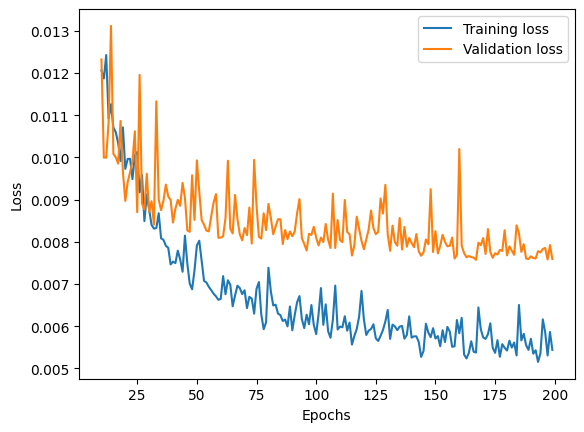

In [57]:
xs = range(10, len(training_loss))
plt.plot(xs, training_loss[10:], label = 'Training loss')
plt.plot(xs, validation_loss[10:], label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.yscale('log')
plt.legend()
plt.show()

85/85 [==============================] - 1s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


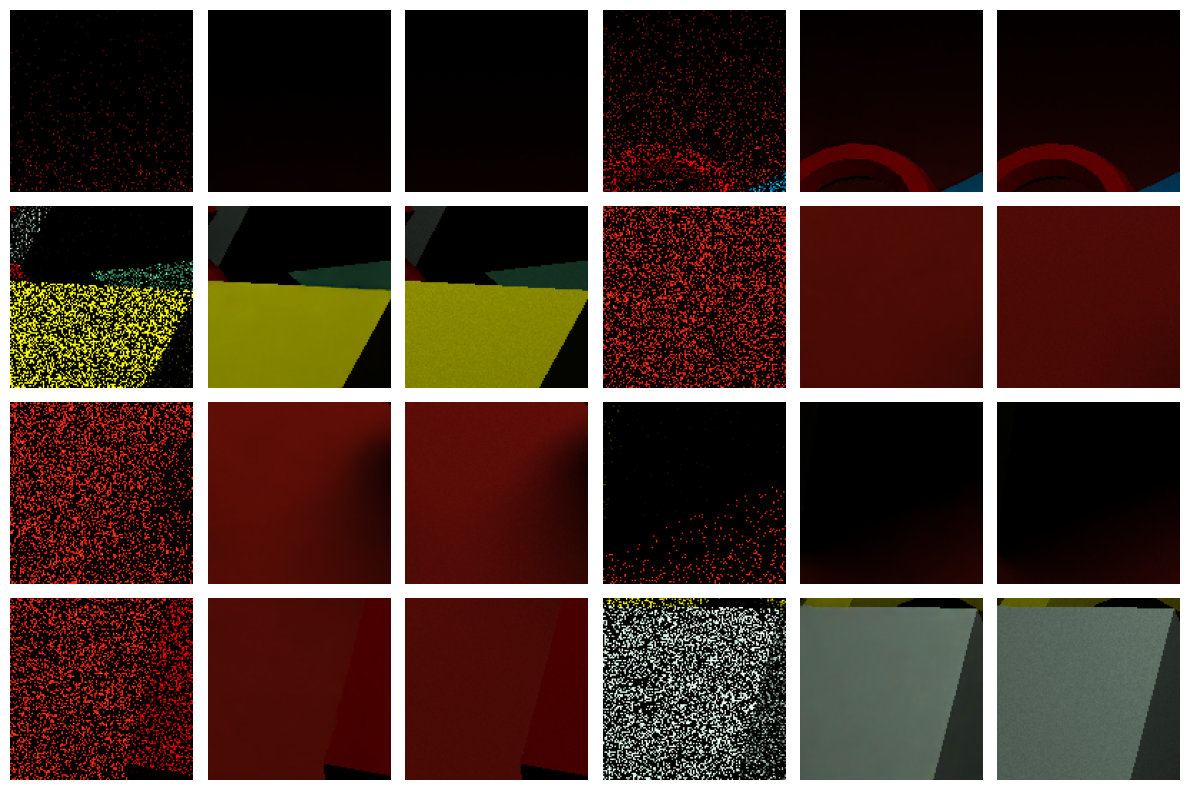

In [49]:
# Make predictions on the training data
predictions = tf.convert_to_tensor(model.predict(tiles_input))

display_tile_grid([tiles_input, predictions, tiles_expected])

## Evaluation

2/2 [==============================] - 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


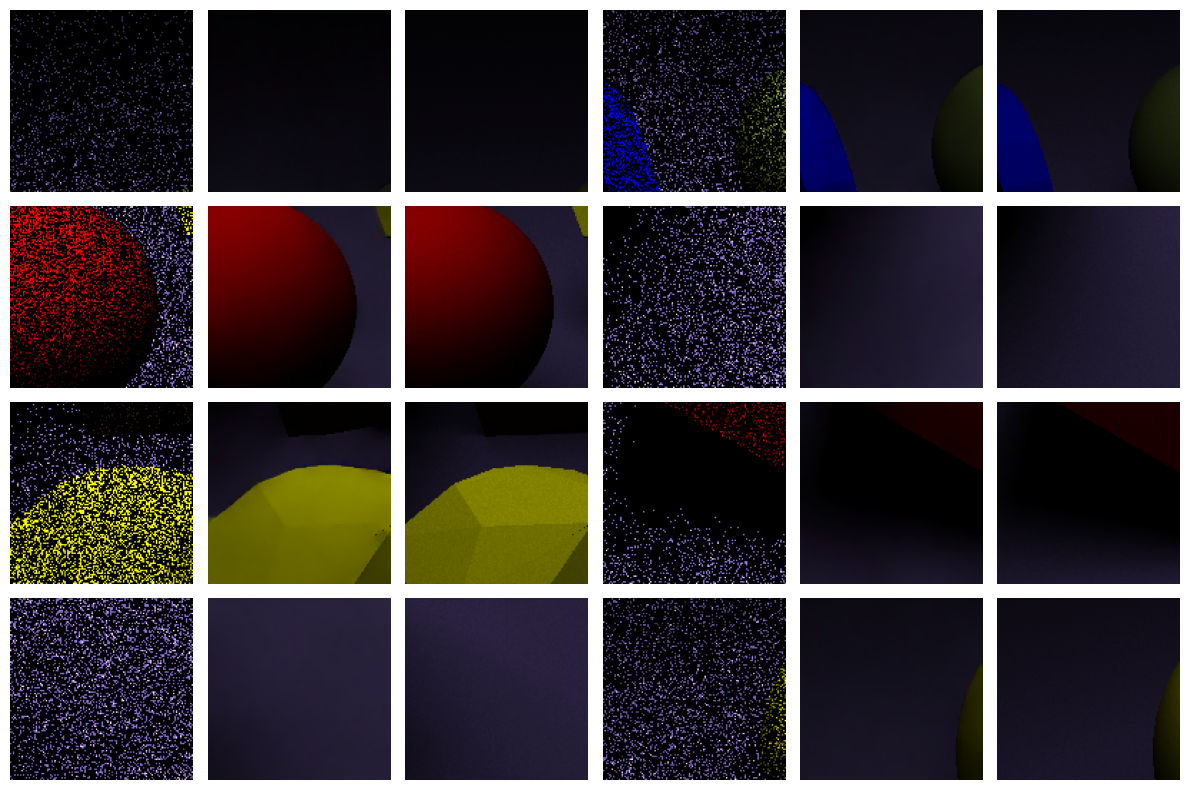

In [50]:
# Make predictions on the evaluation data
test_predictions = tf.convert_to_tensor(model.predict(validation_tiles_input))

display_tile_grid([validation_tiles_input, test_predictions, validation_tiles_expected], lines_count=4)

In [51]:
for id in [str(i).zfill(4) for i in range(30, 36)]:
    img = read_image_file('data/output-' + id + '/raw-output-00004-a', geometry_file='data/output-' + id + '/geometry')

    output = model.predict(tf.convert_to_tensor([img]))[0]

    image = Image.fromarray((output * 255).astype(np.uint8))
    image.save('outputs/scene-' + id + '-model-' + MODEL_NAME + '.png')

1/1 [==============================] - 0s 15ms/step


## Save the coefficients

In [52]:
coefs = []

for layer in model.layers:
    if layer.name[:6] != 'conv2d':
        continue

    weights = layer.weights[0]
    biais = layer.weights[1]

    print(weights.shape, biais.shape)

    coefs += tf.reshape(weights, [int(tf.size(weights))]).numpy().tolist()
    coefs += tf.reshape(biais, [int(tf.size(biais))]).numpy().tolist()

    coefs.append(1)

# Write to the file
output_file = open('models/coefs-' + MODEL_NAME, 'w')

output_file.write(str(len(coefs)) + '\n')

for c in coefs:
    output_file.write(str(c) + ' ')

output_file.close()

(3, 3, 7, 32) (32,)
(3, 3, 32, 43) (43,)
(3, 3, 43, 57) (57,)
(3, 3, 57, 76) (76,)
(3, 3, 76, 101) (101,)
(3, 3, 101, 101) (101,)
(3, 3, 202, 101) (101,)
(3, 3, 101, 101) (101,)
(3, 3, 177, 76) (76,)
(3, 3, 76, 76) (76,)
(3, 3, 133, 57) (57,)
(3, 3, 57, 57) (57,)
(3, 3, 100, 43) (43,)
(3, 3, 43, 43) (43,)
(3, 3, 75, 32) (32,)
(3, 3, 32, 3) (3,)
